## Setup

### GPU Usage

In [1]:
!nvidia-smi
!nvidia-smi -L

Sun Jun 30 16:26:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     Off | 00000000:02:00.0 Off |                    0 |
|  0%   40C    P0              77W / 300W |  10018MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

from time_series_generation import *
from phid import *
from graph_theoretical_analysis import *
from cognitive_tasks_analysis import *
from cognitive_tasks_vs_syn_red_analysis import *
from lda import *
from hf_token import TOKEN

from huggingface_hub import login
from transformers import AutoTokenizer, AutoConfig 
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the Model

In [3]:
if constants.LOAD_MODEL:
    device = torch.device("cuda")
    login(token = TOKEN)
    attn_implementation="eager" # GEMMA_ATTENTION_CLASSES = {"eager": GemmaAttention, "flash_attention_2": GemmaFlashAttention2, "sdpa": GemmaSdpaAttention,}


    tokenizer = AutoTokenizer.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR_BITBUCKET)
    model = AutoModelForCausalLM.from_pretrained(
        constants.MODEL_NAME, 
        cache_dir=constants.CACHE_DIR_BITBUCKET, 
        device_map='auto', 
        attn_implementation=attn_implementation, # Make sure to use the adequate attention layer in order to 
    )
    model.eval()
    print("Loaded Model Name: ", model.config.name_or_path)
    print("Model: ", model)
    print("Attention Layers Implementation: ", model.config._attn_implementation)
    print(f"Number of layers: {constants.NUM_LAYERS}")
    print(f"Number of attention heads per layer: {constants.NUM_HEADS_PER_LAYER}")

### Simple Prompt

In [4]:
if constants.LOAD_MODEL:
    prompt = "What is the sum of 457 and 674? Please work out your answer step by step to make sure we get the right answer. "
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            inputs['input_ids'],
            max_new_tokens=20,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            attention_mask=inputs['attention_mask']  # Provide attention mask for reliable results
        )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)

### Autoregresive Sampling

In [5]:
if constants.LOAD_MODEL:
    # prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
    prompt = "What is the sum of 457 and 674?"# Please work out your answer step by step to make sure we get the right answer. "
    # prompt = "How much is 2 multiplied by 8?"
    # prompt = "Write a very creative story about a dragon that lives in a cave and breathes fire"
    num_tokens_to_generate = 100
    generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, 
        temperature=0.3, modified_output_attentions=constants.MODIFIED_OUTPUT_ATTENTIONS)
    time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
    print(attention_params[constants.ATTENTION_MEASURE].shape)
    print(generated_text)

## Raw Attention and Time Series Generation

In [6]:
random_input_length, num_tokens_to_generate, temperature = 24, 100, 0.3
generated_text = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}
attention_params = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}
time_series = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}

print("Loading Raw Attention and Time Series")
for cognitive_task in constants.PROMPT_CATEGORIES:
    print("Loading Cognitive Task: ", cognitive_task)
    for n_prompt, prompt in enumerate(constants.PROMPTS[cognitive_task]):
        time_series[cognitive_task][n_prompt] = load_time_series(base_load_path=constants.TIME_SERIES_DIR+cognitive_task+"/"+str(n_prompt) + ".pt")
        plot_attention_metrics_norms_over_time(time_series[cognitive_task][n_prompt], metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, smoothing_window=10, 
            save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_TIME_SERIES_DIR+cognitive_task+"/"+str(n_prompt)+"/")

Loading Raw Attention and Time Series
Loading Cognitive Task:  simple_maths
Loading Cognitive Task:  syntax_and_grammar_correction
Loading Cognitive Task:  part_of_speech_tagging
Loading Cognitive Task:  basic_common_sense_reasoning
Loading Cognitive Task:  abstract_reasoning_and_creative_thinking
Loading Cognitive Task:  emotional_intelligence_and_social_cognition


## $\Phi$ ID Computations

### Compute and Save PhiID Matrices given time_series Dictionary

In [7]:
def plot_synergy_matrix(synergy_matrix, title, ax, vmin, vmax):
    cax = ax.matshow(synergy_matrix, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel('Attention Head')
    ax.set_ylabel('Attention Head')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')
    return cax

def plot_all_synergy_matrices(synergy_matrices, base_plot_path=None, save=True):
    categories = constants.PROMPT_CATEGORIES
    num_categories = len(categories)
    rows, cols = 3, 2  # 3x2 matrix

    for metric in constants.METRICS_TRANSFORMER:
        # Find global min and max for color scaling
        all_values = np.concatenate([synergy_matrices[category][metric].flatten() for category in categories])
        vmin, vmax = all_values.min(), all_values.max()

        fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
        fig.subplots_adjust(right=0.8)  # Adjust subplots to leave space for the colorbar
        cax = None
        for i, category in enumerate(categories):
            row, col = divmod(i, cols)
            synergy_matrix = synergy_matrices[category][metric]
            cax = plot_synergy_matrix(synergy_matrix, category, axs[row, col], vmin, vmax)
        
        # Create a single colorbar
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])  # [left, bottom, width, height]
        fig.colorbar(cax, cax=cbar_ax)

        if save:
            if base_plot_path is None:
                base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_DIR + 'all_synergy_matrices/'
            plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to fit colorbar
            os.makedirs(base_plot_path, exist_ok=True)
            plt.savefig(os.path.join(base_plot_path, metric + '.png'))
        else:
            plt.show()
        plt.close()
# plot_all_synergy_matrices(synergy_matrices, save=True)


In [10]:
ranks_per_layer_mean = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}
ranks_per_layer_std = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}
global_matrices = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}
synergy_matrices = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}
redundancy_matrices = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}

for prompt_category_name in constants.PROMPT_CATEGORIES:
    print("Plotting Prompt Category: ", prompt_category_name,)
    for n_prompt, prompt in enumerate(constants.PROMPTS[prompt_category_name]):
        print("Prompt Number: ", n_prompt)

    
        global_matrices[prompt_category_name][n_prompt], synergy_matrices[prompt_category_name][n_prompt], redundancy_matrices[prompt_category_name][n_prompt] = load_matrices(base_save_path=constants.MATRICES_DIR + prompt_category_name + '/' + str(n_prompt) + '.pt')
        plot_synergy_redundancy_PhiID( synergy_matrices[prompt_category_name][n_prompt], redundancy_matrices[prompt_category_name][n_prompt], 
                                      save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/' + str(n_prompt) + '/')
        plot_all_PhiID(global_matrices[prompt_category_name][n_prompt], save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/' + str(n_prompt) + '/')

        base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/' + str(n_prompt) + '/'
        averages = calculate_average_synergy_redundancies_per_head(synergy_matrices[prompt_category_name][n_prompt], redundancy_matrices[prompt_category_name][n_prompt], 
                                                                   within_layer=False)
        plot_averages_per_head(averages, save=constants.SAVE_PLOTS, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)
        # plot_averages_per_layer(averages, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
        gradient_ranks = compute_gradient_rank(averages)
        plot_gradient_rank(gradient_ranks, base_plot_path=base_plot_path, save=constants.SAVE_PLOTS, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
        ranks_per_layer_mean[prompt_category_name], ranks_per_layer_std[prompt_category_name] = plot_average_ranks_per_layer(gradient_ranks, save=constants.SAVE_PLOTS, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)

        # Graph Theoretical Analysis
        graph_theoretical_results = load_graph_theoretical_results(base_save_path=constants.GRAPH_METRICS_DIR + prompt_category_name + '/', file_name=str(n_prompt))
        plot_graph_theoretical_results(graph_theoretical_results, save=constants.SAVE_PLOTS, base_plot_path=base_plot_path)

Plotting Prompt Category:  simple_maths

Prompt:  If you have 15 apples and you give away 5, how many do you have left?

Prompt:  A rectangle's length is twice its width. If the rectangle's perimeter is 36 meters, what are its length and width?

Prompt:  You read 45 pages of a book each day. How many pages will you have read after 7 days?

Prompt:  If a train travels 60 miles in 1 hour, how far will it travel in 3 hours?

Prompt:  There are 8 slices in a pizza. If you eat 2 slices, what fraction of the pizza is left?

Prompt:  If one pencil costs 50 cents, how much do 12 pencils cost?

Prompt:  You have a 2-liter bottle of soda. If you pour out 500 milliliters, how much soda is left?

Prompt:  A marathon is 42 kilometers long. If you have run 10 kilometers, how much further do you have to run?


### Synergy and Redundancy Plots for Concrete Prompt Category

In [16]:
prompt_category_name = 'average_prompts'
print("\n--- Plotting Prompt Category: ", prompt_category_name, " ---")

# global_matrices, synergy_matrices, redundancy_matrices = load_matrices(0)
global_matrices, synergy_matrices, redundancy_matrices = load_matrices(base_save_path=constants.MATRICES_DIR + prompt_category_name + '/' + prompt_category_name + '.pt')
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
plot_all_PhiID(global_matrices, save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')

base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/'
averages = calculate_average_synergy_redundancies_per_head(synergy_matrices, redundancy_matrices, within_layer=False)
plot_averages_per_head(averages, save=constants.SAVE_PLOTS, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)
# plot_averages_per_layer(averages, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
gradient_ranks = compute_gradient_rank(averages)
plot_gradient_rank(gradient_ranks, base_plot_path=base_plot_path, save=constants.SAVE_PLOTS, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
ranks_per_layer_mean, ranks_per_layer_std = plot_average_ranks_per_layer(gradient_ranks, save=constants.SAVE_PLOTS, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)

# Graph Theoretical Analysis
graph_theoretical_results = load_graph_theoretical_results(base_save_path=constants.GRAPH_METRICS_DIR + prompt_category_name + '/', file_name=prompt_category_name)
plot_graph_theoretical_results(graph_theoretical_results, save=constants.SAVE_PLOTS, base_plot_path=base_plot_path)


--- Plotting Prompt Category:  average_prompts  ---


## Different Heads for Different Cognitive Tasks

### Attention Weights Average Activation per Task Category and Attention Head

In [17]:
base_plot_path = constants.PLOTS_HEAD_ACTIVATIONS_COGNITIVE_TASKS
if constants.GENERATE_ATTENTION_WEIGHTS: 
    print("Generating Attention Weights")
    attention_weights_prompts, generated_text = solve_prompts(constants.PROMPTS, model, tokenizer, device, num_tokens_to_generate=64,temperature=0.7, attention_measure=constants.ATTENTION_MEASURE)
    save_attention_weights(attention_weights_prompts, generated_text)
else:
    print("Loading Attention Weights")
    attention_weights_prompts =  load_attention_weights()

print("Plotting Attention Weights")
summary_stats_prompts = plot_categories_comparison(attention_weights_prompts, save=constants.SAVE_PLOTS, base_plot_path=base_plot_path, split_half=False, split_third=False)
plot_all_heatmaps(attention_weights_prompts, save=constants.SAVE_PLOTS, base_plot_path=base_plot_path)

Loading Attention Weights
Plotting Attention Weights


### LDA Analysis of the Attention Weights

In [29]:
perform_lda_analysis(attention_weights_prompts, save=constants.SAVE_PLOTS, base_plot_path=base_plot_path)

## Synergy Redundancy and Task Correlations

### Categories Correlation

KeyError: 'simple_maths'

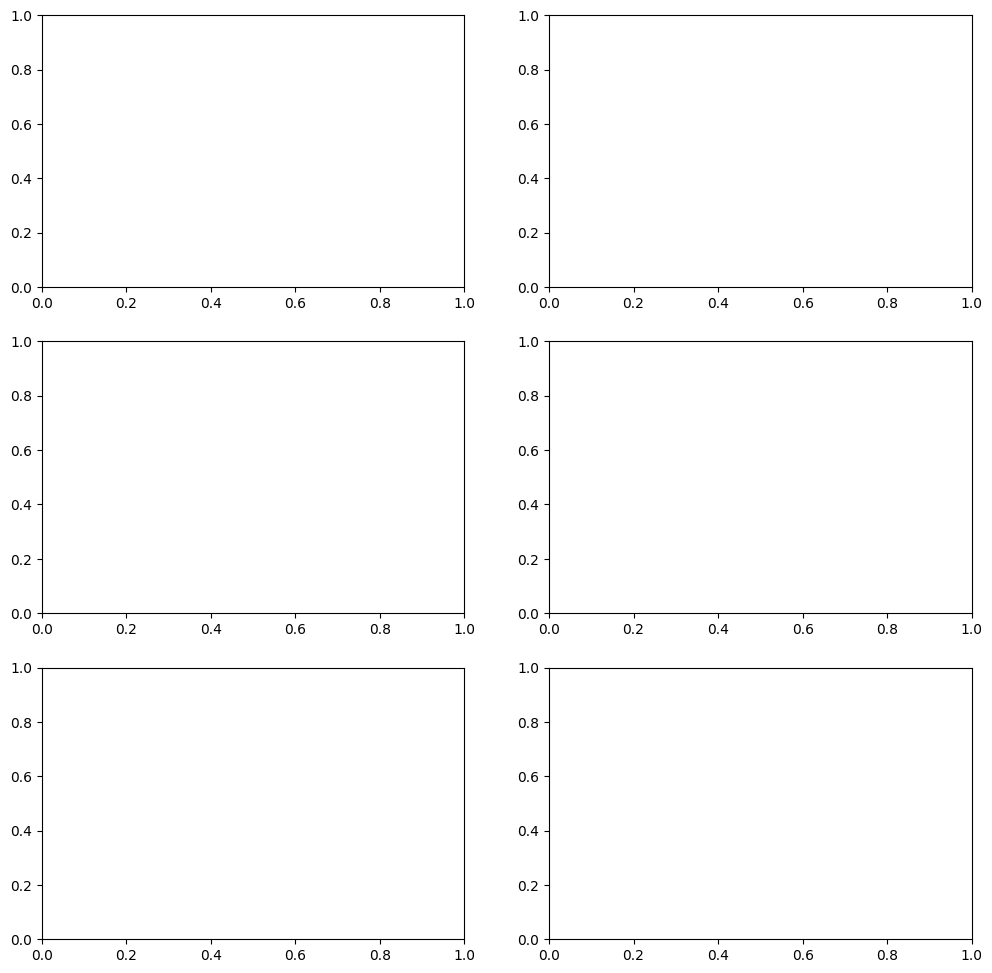

In [46]:
results = plot_all_category_diffs_vs_syn_red_grad_rank(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], ranks_per_layer_mean,
        save=constants.SAVE_PLOTS, reorder=False, per_layer=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, baseline_rest=False)

### Average Rank of Most Significantly Activated Heads by Category

In [18]:
plot_rank_most_activated_heads_per_task(summary_stats_prompts, gradient_ranks, top_ns=[1,3,5,10,30, 50], save=constants.SAVE_PLOTS)

### Top Synergistic and Top Redundant Heads

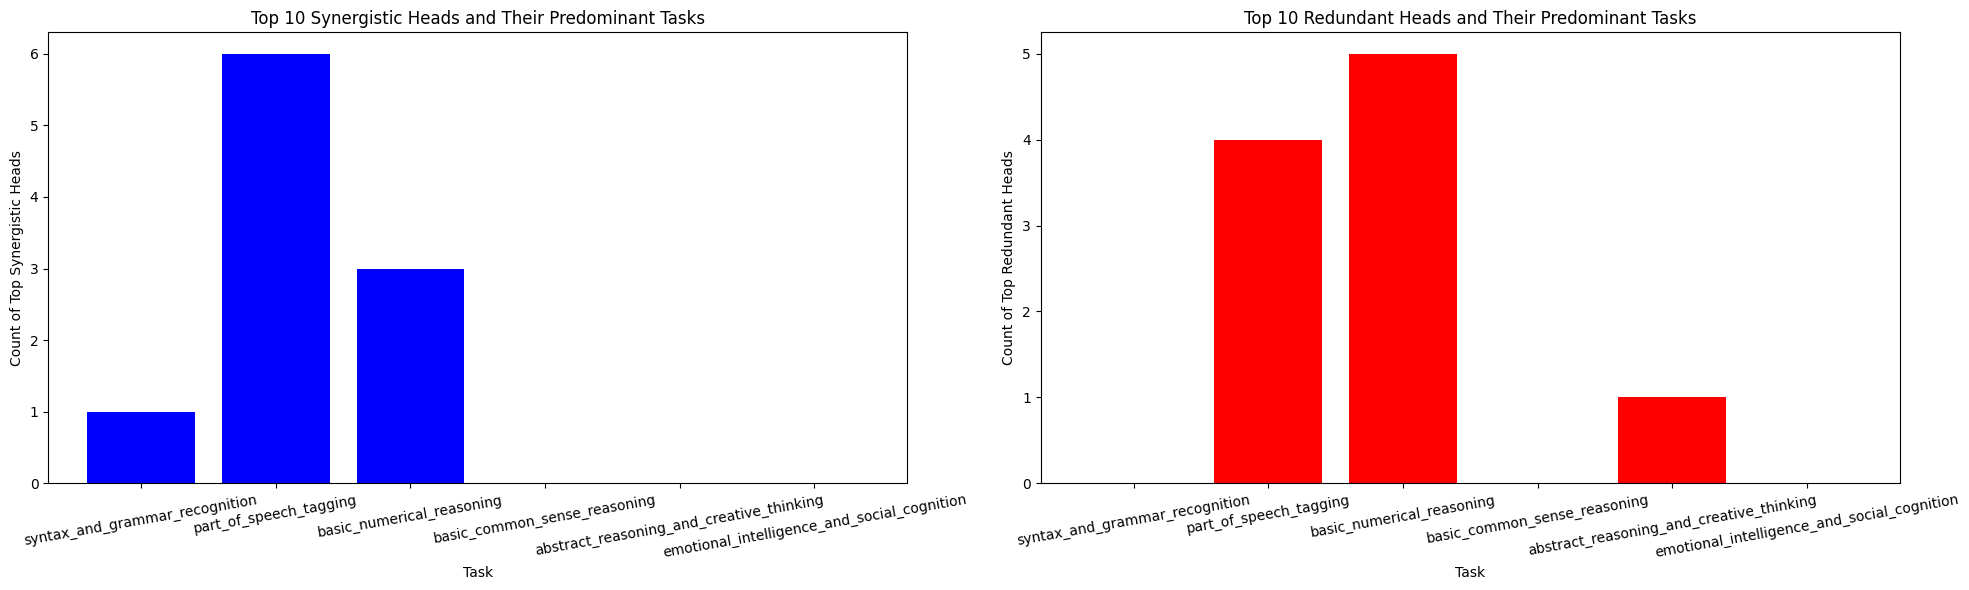

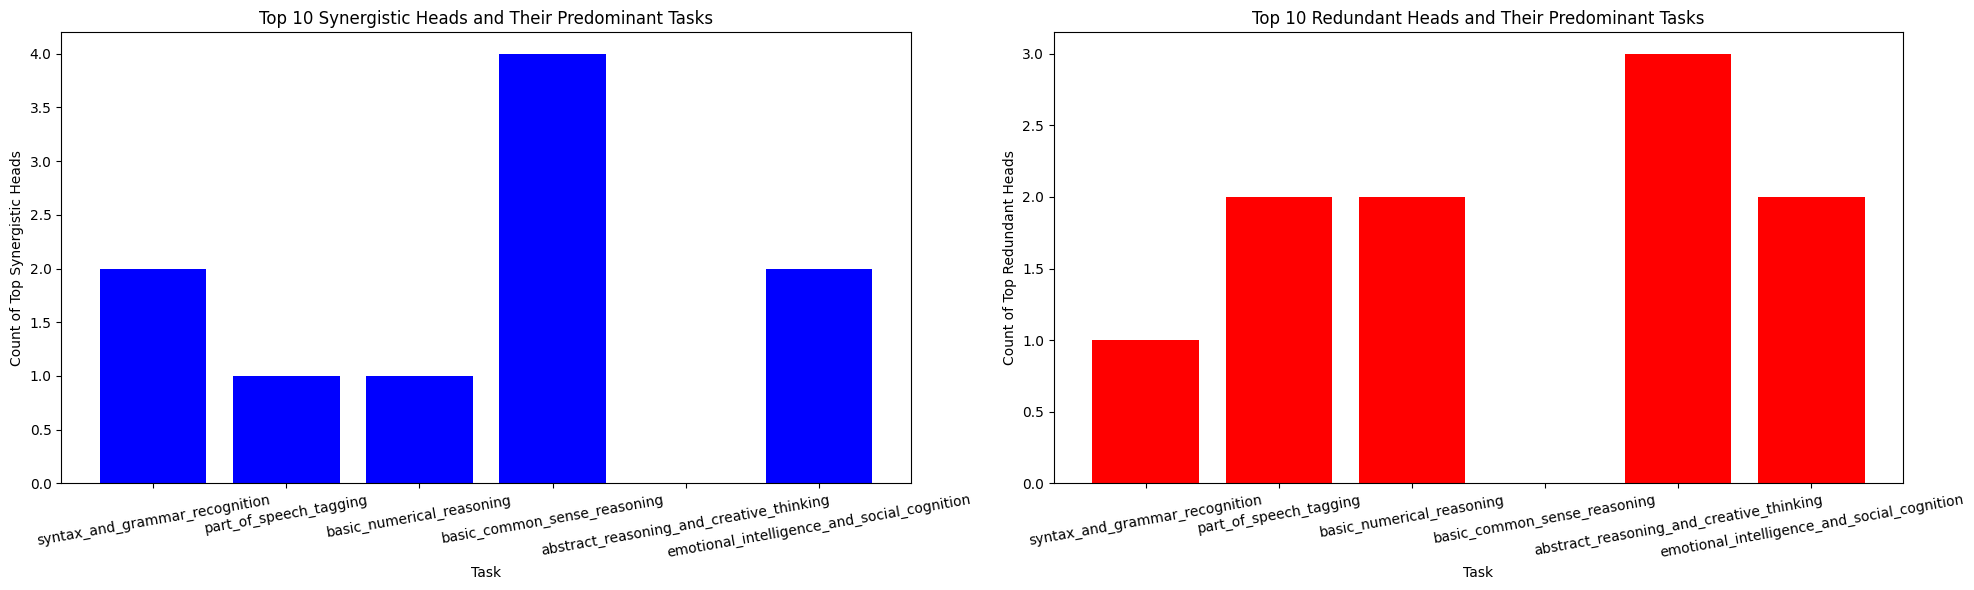

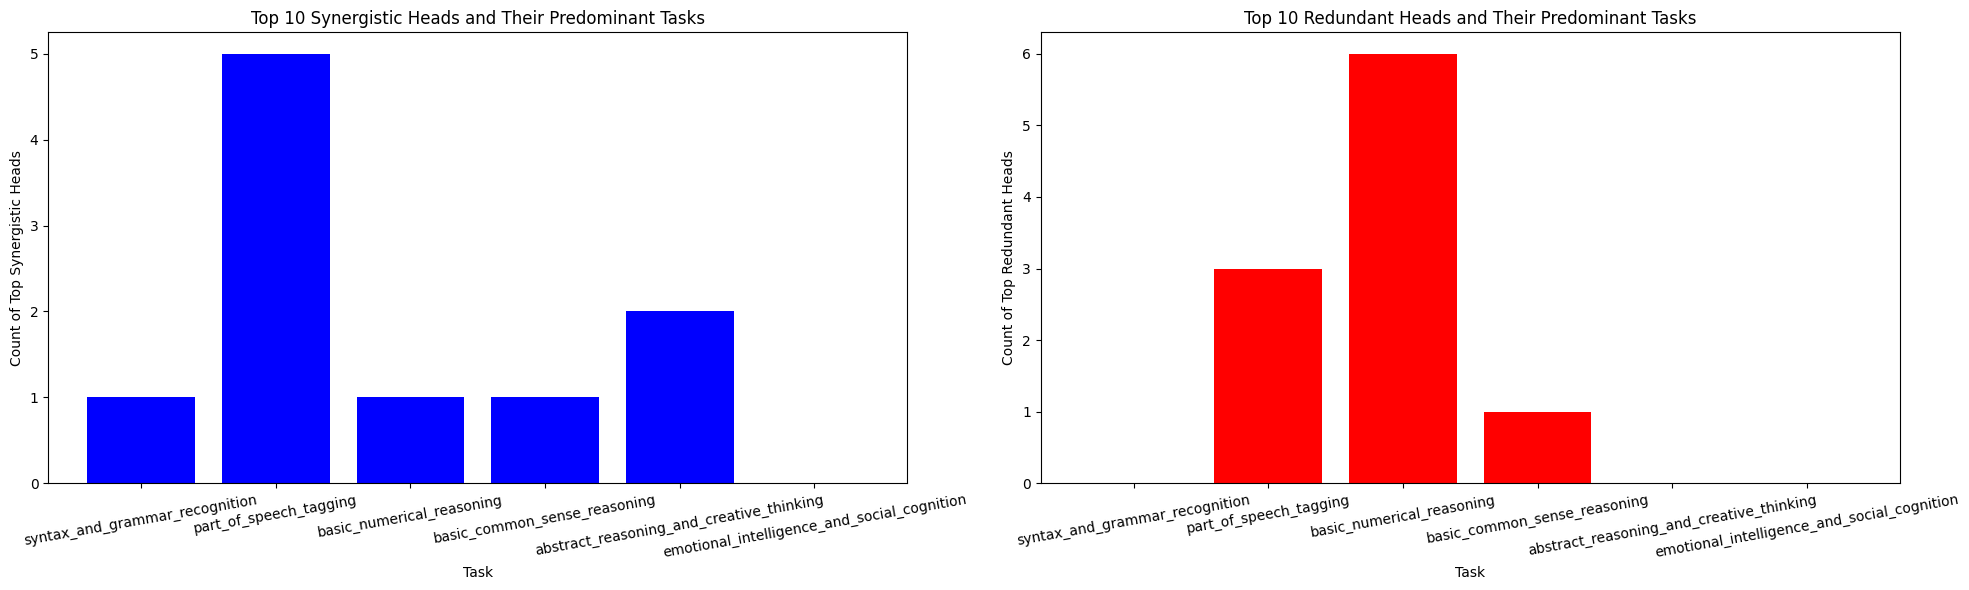

In [11]:
plot_most_syn_red_tasks(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], top_n=10)

### Average Head Activation per Task

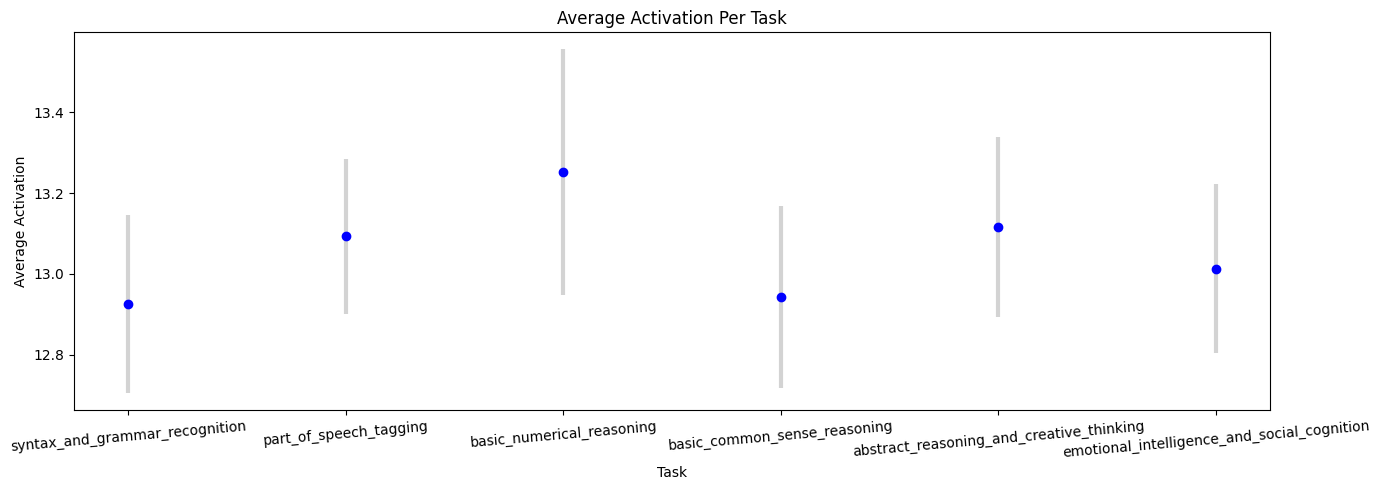

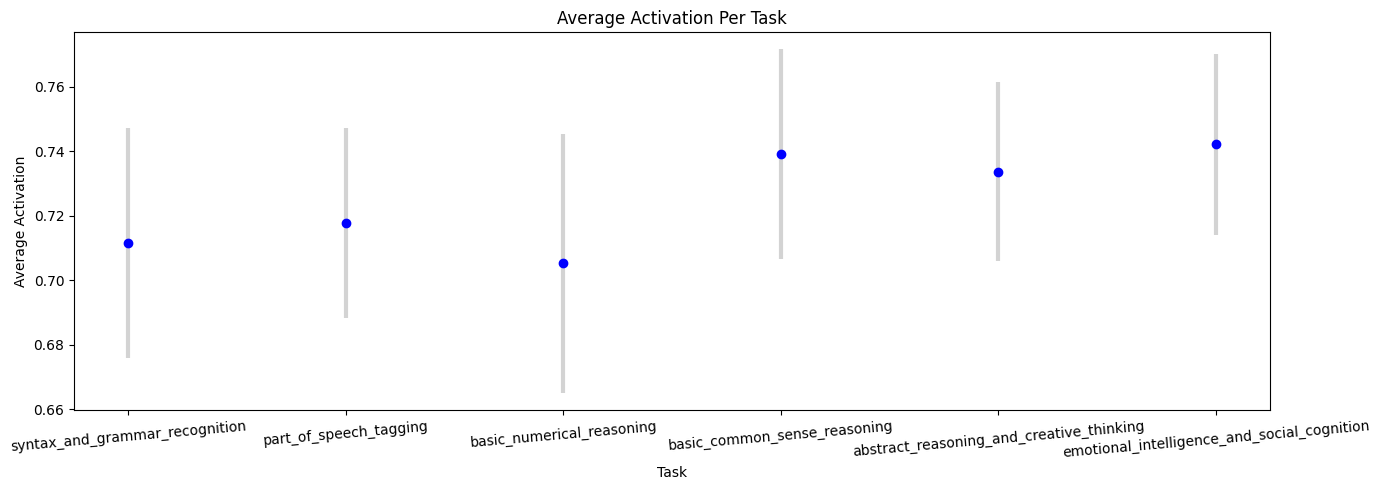

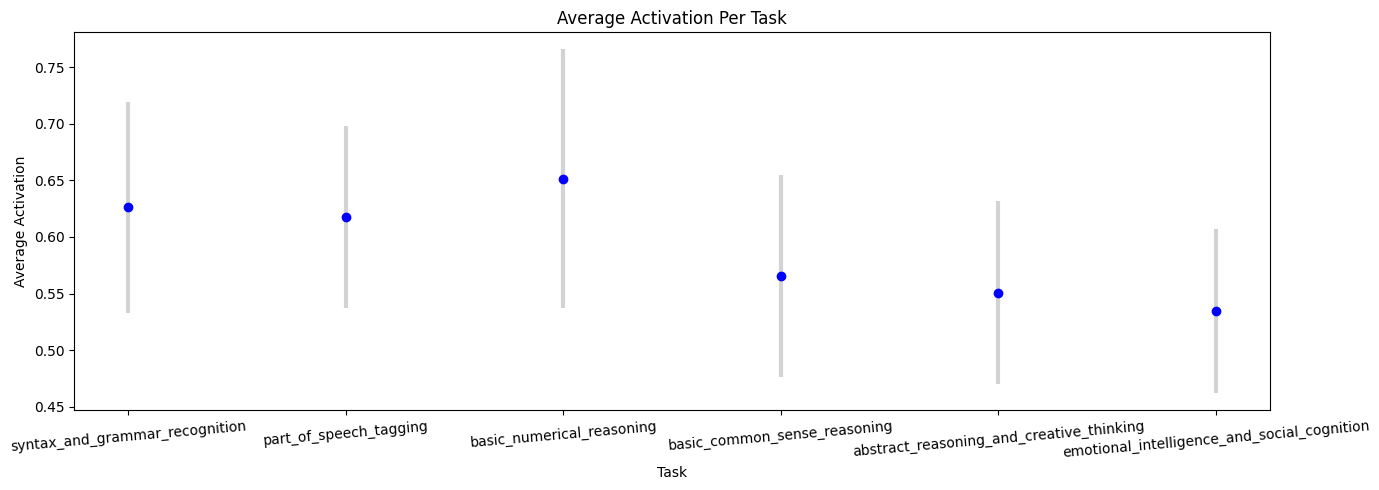

In [16]:
plot_average_head_activation_per_task(summary_stats_prompts)